# Figure 4 (Molina et al., submitted)

Figure 4. Percentage of days of weather regime occurrence for CESM2 (11-member ensemble mean) and corresponding ERA5 data arranged as the CESM2 reforecasts (e.g., weeks 1-2). ERA5 and CESM2 analysis (lead day 0) are indicated in the far left columns, and CESM2 weeks 1-2, 3-4, and 5-6 reforecasts are indicated in the following columns with corresponding ERA5. Weather regimes are indicated in the legend. Error bars represent spread among individual CESM2 ensemble members.

## Imports

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import shapely.geometry as sgeom

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import som_analysis
import cluster_analysis
import narm_analysis

## functions

In [2]:
def add_insetmap(axes_extent, map_extent, lons, lats, temp_data, 
                 vmin, vmax, cmap='coolwarm'):

    use_projection = ccrs.Mercator()     # preserve shape well
    geodetic = ccrs.Geodetic(globe=ccrs.Globe(datum='WGS84'))

    sub_ax = plt.axes(axes_extent, projection=use_projection)  # normal units
    sub_ax.set_extent(map_extent, geodetic)  # map extents
    sub_ax.coastlines(linewidth=0.35, zorder=10)

    sub_ax.pcolormesh(lons, lats, temp_data, transform=ccrs.PlateCarree(),
                      vmin=vmin, vmax=vmax, cmap=cmap)

    extent_box = sgeom.box(
        map_extent[0], map_extent[2], map_extent[1], map_extent[3])
    sub_ax.add_geometries(
        [extent_box], ccrs.PlateCarree(), color='none', linewidth=0.05)

In [3]:
def get_cold_indx(ds, mo_init=9, mo_end=2):
    """
    Extract indices for cold season.
    Grabbing Sept thru February init, for Oct thru March predictions.
    """
    dt_array = pd.to_datetime(ds['time'])
    return xr.where((dt_array.month >= mo_init) | (dt_array.month <= mo_end),
                    True, False)

## open and preprocess data

In [4]:
# region for clustering
lat0 = 10
lat1 = 70
lon0 = -150
lon1 = -40

# open era5 data and slice
ds_era5 = narm_analysis.era5_z500(lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1)

# era5 anomalies
ds_era5_anom = narm_analysis.era5_climo_wrs(
    ds_era5, rolling_days=5, variable='clim')

# restructure era5 array for machine learning training (SONDJFM)
ds_era5_anom = ds_era5_anom[get_cold_indx(
    ds_era5_anom, mo_init=10, mo_end=3), ...]
ds_era5_train = ds_era5_anom.stack(
    flat=('lat', 'lon')).transpose('time', 'flat').values

## pca and kmeans with era5

In [5]:
# create pca object
pca_obj = PCA(12, whiten=True)

# fit pca with era5
pca_obj = pca_obj.fit(ds_era5_train)

# transform era5 data with pca
ds_era5_train = pca_obj.transform(ds_era5_train)

print(f'Variance explained: {pca_obj.explained_variance_ratio_ * 100}')
print(
f'Cumulative sum of variance explained for EOF1 and EOF2: {np.cumsum(pca_obj.explained_variance_ratio_) * 100}'
)

# train kmeans
k_means = KMeans(n_clusters=4,
                 init='k-means++',
                 n_init=10000,
                 max_iter=300,
                 tol=0.0001,
                 verbose=0,
                 random_state=0).fit(ds_era5_train)

print(f'inertia: {k_means.inertia_}')

Variance explained: [25.95315607 17.65410568 11.94871708  9.0784389   7.98100848  6.14181738
  4.32605934  2.61658689  2.22642929  2.17049559  1.49813958  1.22541708]
Cumulative sum of variance explained for EOF1 and EOF2: [25.95315607 43.60726175 55.55597883 64.63441774 72.61542622 78.7572436
 83.08330294 85.69988983 87.92631912 90.09681471 91.59495429 92.82037136]
inertia: 39379.20536868706


## load data with lead time bias corrected anomalies

In [6]:
# era5 data
z500_era5, z500_era5_dt = som_analysis.open_era5_files(
    variable='z500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm data
z500_cesm, z500_cesm_dt = som_analysis.open_cesm_files(
    variable='zg_500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, rolldays=5,)

# cesm ensemble data
z500_ensm, z500_ensm_dt, z_ensm = som_analysis.open_cesm_ensembles(
    variable='zg_500', return_time=True,
    lat0=lat0, lat1=lat1, lon0=lon0, lon1=lon1,
    leadday0=0, leadday1=42, return_ens=True, rolldays=5)

# restructure arrays
z500_standard_era5 = z500_era5.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')
z500_standard_cesm = z500_cesm.stack(
    new=('time', 'lead'), flat=('lat', 'lon')).transpose('new', 'flat')
z500_standard_ensm = z500_ensm.stack(
    new=('time', 'ensemble', 'lead'), 
    flat=('lat', 'lon')).transpose('new', 'flat')

## extract cluster labels

(projecting era5 pca and kmeans onto cesm2)

In [7]:
cluster_era5_evo = cluster_analysis.single_clusters(
    z500_standard_era5, k_means, pca_obj, use_pca=True)
cluster_cesm_evo = cluster_analysis.single_clusters(
    z500_standard_cesm, k_means, pca_obj, use_pca=True)
cluster_ensm_evo = cluster_analysis.ensemble_clusters(
    z500_standard_ensm, k_means, pca_obj, use_pca=True)

## cluster climatology

In [8]:
label_era5_wall, counts_era5_wall = cluster_analysis.cluster_percentages(
    cluster_era5_evo)

label_cesm_wall, counts_cesm_wall = cluster_analysis.cluster_percentages(
    cluster_cesm_evo, np.arange(0, 1, 1))
label_cesm_wk12, counts_cesm_wk12 = cluster_analysis.cluster_percentages(
    cluster_cesm_evo, np.arange(1, 15, 1))
label_cesm_wk34, counts_cesm_wk34 = cluster_analysis.cluster_percentages(
    cluster_cesm_evo, np.arange(15, 28, 1))
label_cesm_wk56, counts_cesm_wk56 = cluster_analysis.cluster_percentages(
    cluster_cesm_evo, np.arange(28, 42, 1))

label_ensm_wall, counts_ensm_wall, stds_ensm_wall = cluster_analysis.cluster_percentages(
    cluster_ensm_evo, np.arange(0, 1, 1))
label_ensm_wk12, counts_ensm_wk12, stds_ensm_wk12 = cluster_analysis.cluster_percentages(
    cluster_ensm_evo, np.arange(1, 15, 1))
label_ensm_wk34, counts_ensm_wk34, stds_ensm_wk34 = cluster_analysis.cluster_percentages(
    cluster_ensm_evo, np.arange(15, 28, 1))
label_ensm_wk56, counts_ensm_wk56, stds_ensm_wk56 = cluster_analysis.cluster_percentages(
    cluster_ensm_evo, np.arange(28, 42, 1))

### previous figure version

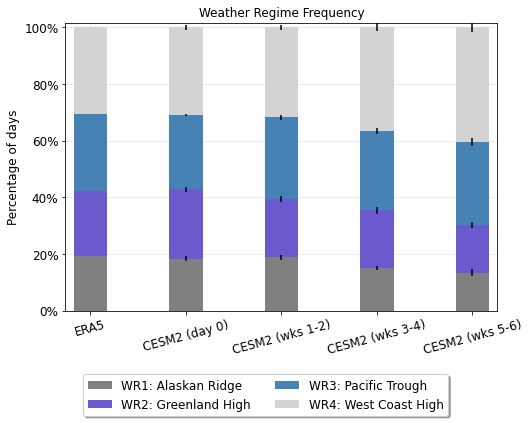

In [9]:
# ---

width = 0.35

# ---

fig = plt.figure(figsize=(6, 4))

# ---

ax = plt.axes([0., 0., 1., 1.])

ax.bar([0], counts_era5_wall[0], width, color='grey', zorder=10)
ax.bar([0], counts_era5_wall[1], width, color='slateblue', bottom=np.sum(counts_era5_wall[0:1]), 
       zorder=10)
ax.bar([0], counts_era5_wall[2], width, color='steelblue', bottom=np.sum(counts_era5_wall[0:2]), 
       zorder=10)
ax.bar([0], counts_era5_wall[3], width, color='lightgrey', bottom=np.sum(counts_era5_wall[0:3]), 
       zorder=10)

ax.bar([1], counts_cesm_wall[0], width, yerr=stds_ensm_wall[0], color='grey', zorder=10)
ax.bar([1], counts_cesm_wall[1], width, yerr=stds_ensm_wall[1], color='slateblue', 
       bottom=np.sum(counts_cesm_wall[0:1]), zorder=10)
ax.bar([1], counts_cesm_wall[2], width, yerr=stds_ensm_wall[2], color='steelblue', 
       bottom=np.sum(counts_cesm_wall[0:2]), zorder=10)
ax.bar([1], counts_cesm_wall[3], width, yerr=stds_ensm_wall[3], color='lightgrey', 
       bottom=np.sum(counts_cesm_wall[0:3]), zorder=10)

ax.bar([2], counts_cesm_wk12[0], width, yerr=stds_ensm_wk12[0], color='grey', zorder=10)
ax.bar([2], counts_cesm_wk12[1], width, yerr=stds_ensm_wk12[1], color='slateblue', 
       bottom=np.sum(counts_cesm_wk12[0:1]), zorder=10)
ax.bar([2], counts_cesm_wk12[2], width, yerr=stds_ensm_wk12[2], color='steelblue', 
       bottom=np.sum(counts_cesm_wk12[0:2]), zorder=10)
ax.bar([2], counts_cesm_wk12[3], width, yerr=stds_ensm_wk12[3], color='lightgrey', 
       bottom=np.sum(counts_cesm_wk12[0:3]), zorder=10)

ax.bar([3], counts_cesm_wk34[0], width, yerr=stds_ensm_wk34[0], color='grey', zorder=10)
ax.bar([3], counts_cesm_wk34[1], width, yerr=stds_ensm_wk34[1], color='slateblue', 
       bottom=np.sum(counts_cesm_wk34[0:1]), zorder=10)
ax.bar([3], counts_cesm_wk34[2], width, yerr=stds_ensm_wk34[2], color='steelblue', 
       bottom=np.sum(counts_cesm_wk34[0:2]), zorder=10)
ax.bar([3], counts_cesm_wk34[3], width, yerr=stds_ensm_wk34[3], color='lightgrey', 
       bottom=np.sum(counts_cesm_wk34[0:3]), zorder=10)

ls0, = ax.bar([4], counts_cesm_wk56[0], width, yerr=stds_ensm_wk56[0], color='grey', zorder=10)
ls1, = ax.bar([4], counts_cesm_wk56[1], width, yerr=stds_ensm_wk56[1], color='slateblue', 
       bottom=np.sum(counts_cesm_wk56[0:1]), zorder=10)
ls2, = ax.bar([4], counts_cesm_wk56[2], width, yerr=stds_ensm_wk56[2], color='steelblue', 
       bottom=np.sum(counts_cesm_wk56[0:2]), zorder=10)
ls3, = ax.bar([4], counts_cesm_wk56[3], width, yerr=stds_ensm_wk56[3], color='lightgrey', 
       bottom=np.sum(counts_cesm_wk56[0:3]), zorder=10)

#ax.set_xlabel('Data product', fontsize=12)
ax.set_xticks([0,1,2,3,4])
ax.set_xticklabels(['ERA5','CESM2 (day 0)', 'CESM2 (wks 1-2)', 'CESM2 (wks 3-4)', 'CESM2 (wks 5-6)'],
                   fontsize=12, rotation=15)

ax.set_ylabel('Percentage of days', fontsize=12)
ax.set_yticks([0,0.2,0.4,0.6,0.8,1.0])
ax.set_yticklabels(['0%','20%','40%','60%','80%','100%'], fontsize=12)

ax.margins(x=0.02, y=0)
ax.grid('--', lw=0.5, alpha=0.5, zorder=1)
ax.legend([ls0, ls1, ls2, ls3],
          ['WR1: Alaskan Ridge',
           'WR2: Greenland High',
           'WR3: Pacific Trough',
           'WR4: West Coast High'],
           ncol=2, bbox_to_anchor=(0.9, -0.2), 
           fancybox=True, shadow=True, fontsize=12)

ax.set_title('Weather Regime Frequency', fontsize=12)

# ---

plt.savefig("fig_wrfreq.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

In [10]:
label_era5_wall, counts_era5_wall = cluster_analysis.cluster_percentages(
    cluster_era5_evo, np.arange(0, 1, 1))
label_era5_wk12, counts_era5_wk12 = cluster_analysis.cluster_percentages(
    cluster_era5_evo, np.arange(1, 15, 1))
label_era5_wk34, counts_era5_wk34 = cluster_analysis.cluster_percentages(
    cluster_era5_evo, np.arange(15, 28, 1))
label_era5_wk56, counts_era5_wk56 = cluster_analysis.cluster_percentages(
    cluster_era5_evo, np.arange(28, 42, 1))

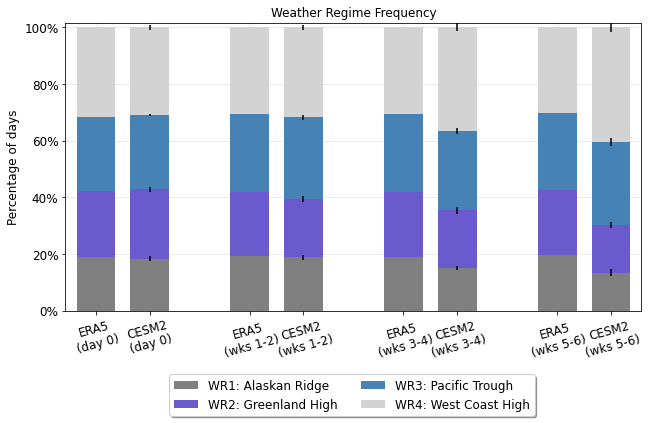

In [11]:
# ---

width = 0.25

# ---

fig = plt.figure(figsize=(8, 4))

# ---

ax = plt.axes([0., 0., 1., 1.])

# day 0

ax.bar([0], counts_era5_wall[0], width, color='grey', zorder=10)
ax.bar([0], counts_era5_wall[1], width, color='slateblue',
       bottom=np.sum(counts_era5_wall[0:1]), zorder=10)
ax.bar([0], counts_era5_wall[2], width, color='steelblue',
       bottom=np.sum(counts_era5_wall[0:2]), zorder=10)
ax.bar([0], counts_era5_wall[3], width, color='lightgrey',
       bottom=np.sum(counts_era5_wall[0:3]), zorder=10)

ax.bar([0.35], counts_cesm_wall[0], width, yerr=stds_ensm_wall[0],
       color='grey', zorder=10)
ax.bar([0.35], counts_cesm_wall[1], width, yerr=stds_ensm_wall[1],
       color='slateblue', bottom=np.sum(counts_cesm_wall[0:1]), zorder=10)
ax.bar([0.35], counts_cesm_wall[2], width, yerr=stds_ensm_wall[2],
       color='steelblue', bottom=np.sum(counts_cesm_wall[0:2]), zorder=10)
ax.bar([0.35], counts_cesm_wall[3], width, yerr=stds_ensm_wall[3],
       color='lightgrey', bottom=np.sum(counts_cesm_wall[0:3]), zorder=10)

# weeks 1-2

ax.bar([1.0], counts_era5_wk12[0], width, color='grey', zorder=10)
ax.bar([1.0], counts_era5_wk12[1], width, color='slateblue',
       bottom=np.sum(counts_era5_wk12[0:1]), zorder=10)
ax.bar([1.0], counts_era5_wk12[2], width, color='steelblue',
       bottom=np.sum(counts_era5_wk12[0:2]), zorder=10)
ax.bar([1.0], counts_era5_wk12[3], width, color='lightgrey',
       bottom=np.sum(counts_era5_wk12[0:3]), zorder=10)

ax.bar([1.35], counts_cesm_wk12[0], width, yerr=stds_ensm_wk12[0],
       color='grey', zorder=10)
ax.bar([1.35], counts_cesm_wk12[1], width, yerr=stds_ensm_wk12[1],
       color='slateblue', bottom=np.sum(counts_cesm_wk12[0:1]), zorder=10)
ax.bar([1.35], counts_cesm_wk12[2], width, yerr=stds_ensm_wk12[2],
       color='steelblue', bottom=np.sum(counts_cesm_wk12[0:2]), zorder=10)
ax.bar([1.35], counts_cesm_wk12[3], width, yerr=stds_ensm_wk12[3],
       color='lightgrey', bottom=np.sum(counts_cesm_wk12[0:3]), zorder=10)

# weeks 3-4

ax.bar([2.0], counts_era5_wk34[0], width, color='grey', zorder=10)
ax.bar([2.0], counts_era5_wk34[1], width, color='slateblue',
       bottom=np.sum(counts_era5_wk34[0:1]), zorder=10)
ax.bar([2.0], counts_era5_wk34[2], width, color='steelblue',
       bottom=np.sum(counts_era5_wk34[0:2]), zorder=10)
ax.bar([2.0], counts_era5_wk34[3], width, color='lightgrey',
       bottom=np.sum(counts_era5_wk34[0:3]), zorder=10)

ax.bar([2.35], counts_cesm_wk34[0], width, yerr=stds_ensm_wk34[0],
       color='grey', zorder=10)
ax.bar([2.35], counts_cesm_wk34[1], width, yerr=stds_ensm_wk34[1],
       color='slateblue', bottom=np.sum(counts_cesm_wk34[0:1]), zorder=10)
ax.bar([2.35], counts_cesm_wk34[2], width, yerr=stds_ensm_wk34[2],
       color='steelblue', bottom=np.sum(counts_cesm_wk34[0:2]), zorder=10)
ax.bar([2.35], counts_cesm_wk34[3], width, yerr=stds_ensm_wk34[3],
       color='lightgrey', bottom=np.sum(counts_cesm_wk34[0:3]), zorder=10)

# weeks 5-6

ax.bar([3.0], counts_era5_wk56[0], width, color='grey', zorder=10)
ax.bar([3.0], counts_era5_wk56[1], width, color='slateblue',
       bottom=np.sum(counts_era5_wk56[0:1]), zorder=10)
ax.bar([3.0], counts_era5_wk56[2], width, color='steelblue',
       bottom=np.sum(counts_era5_wk56[0:2]), zorder=10)
ax.bar([3.0], counts_era5_wk56[3], width, color='lightgrey',
       bottom=np.sum(counts_era5_wk56[0:3]), zorder=10)

ls0, = ax.bar([3.35], counts_cesm_wk56[0], width, yerr=stds_ensm_wk56[0],
              color='grey', zorder=10)
ls1, = ax.bar([3.35], counts_cesm_wk56[1], width, yerr=stds_ensm_wk56[1],
              color='slateblue', bottom=np.sum(counts_cesm_wk56[0:1]), zorder=10)
ls2, = ax.bar([3.35], counts_cesm_wk56[2], width, yerr=stds_ensm_wk56[2],
              color='steelblue', bottom=np.sum(counts_cesm_wk56[0:2]), zorder=10)
ls3, = ax.bar([3.35], counts_cesm_wk56[3], width, yerr=stds_ensm_wk56[3],
              color='lightgrey', bottom=np.sum(counts_cesm_wk56[0:3]), zorder=10)

ax.set_xticks([0, 0.35, 1, 1.35, 2, 2.35, 3, 3.35])
ax.set_xticklabels(['ERA5\n(day 0)', 'CESM2\n(day 0)',
                    'ERA5\n(wks 1-2)', 'CESM2\n(wks 1-2)',
                    'ERA5\n(wks 3-4)', 'CESM2\n(wks 3-4)',
                    'ERA5\n(wks 5-6)', 'CESM2\n(wks 5-6)'],
                   fontsize=12, rotation=15)

ax.set_ylabel('Percentage of days', fontsize=12)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=12)

ax.margins(x=0.02, y=0)
ax.grid('--', lw=0.5, alpha=0.5, zorder=1)
ax.legend([ls0, ls1, ls2, ls3],
          ['WR1: Alaskan Ridge',
           'WR2: Greenland High',
           'WR3: Pacific Trough',
           'WR4: West Coast High'], ncol=2,
          bbox_to_anchor=(0.825, -0.2),
          fancybox=True, shadow=True, fontsize=12)

ax.set_title('Weather Regime Frequency', fontsize=12)

# ---

plt.savefig("fig_wrfreq_v2.png", bbox_inches='tight', dpi=500)
plt.show()

# ---

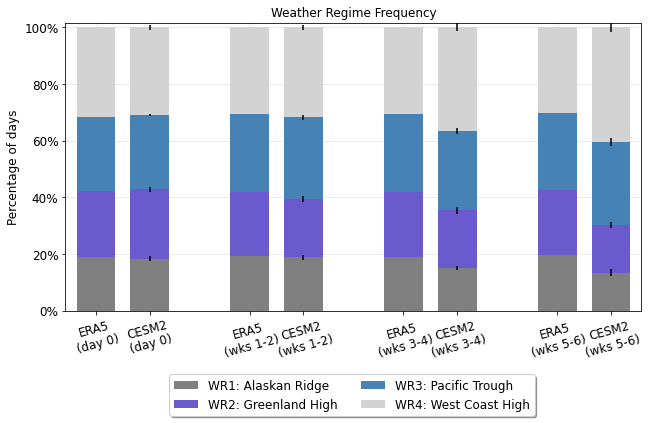

In [12]:
# ---

width = 0.25

# ---

fig = plt.figure(figsize=(8, 4))

# ---

ax = plt.axes([0., 0., 1., 1.])

# day 0

ax.bar([0], counts_era5_wall[0], width, color='grey', zorder=10)
ax.bar([0], counts_era5_wall[1], width, color='slateblue',
       bottom=np.sum(counts_era5_wall[0:1]), zorder=10)
ax.bar([0], counts_era5_wall[2], width, color='steelblue',
       bottom=np.sum(counts_era5_wall[0:2]), zorder=10)
ax.bar([0], counts_era5_wall[3], width, color='lightgrey',
       bottom=np.sum(counts_era5_wall[0:3]), zorder=10)

ax.bar([0.35], counts_cesm_wall[0], width, yerr=stds_ensm_wall[0],
       color='grey', zorder=10)
ax.bar([0.35], counts_cesm_wall[1], width, yerr=stds_ensm_wall[1],
       color='slateblue', bottom=np.sum(counts_cesm_wall[0:1]), zorder=10)
ax.bar([0.35], counts_cesm_wall[2], width, yerr=stds_ensm_wall[2],
       color='steelblue', bottom=np.sum(counts_cesm_wall[0:2]), zorder=10)
ax.bar([0.35], counts_cesm_wall[3], width, yerr=stds_ensm_wall[3],
       color='lightgrey', bottom=np.sum(counts_cesm_wall[0:3]), zorder=10)

# weeks 1-2

ax.bar([1.0], counts_era5_wk12[0], width, color='grey', zorder=10)
ax.bar([1.0], counts_era5_wk12[1], width, color='slateblue',
       bottom=np.sum(counts_era5_wk12[0:1]), zorder=10)
ax.bar([1.0], counts_era5_wk12[2], width, color='steelblue',
       bottom=np.sum(counts_era5_wk12[0:2]), zorder=10)
ax.bar([1.0], counts_era5_wk12[3], width, color='lightgrey',
       bottom=np.sum(counts_era5_wk12[0:3]), zorder=10)

ax.bar([1.35], counts_cesm_wk12[0], width, yerr=stds_ensm_wk12[0],
       color='grey', zorder=10)
ax.bar([1.35], counts_cesm_wk12[1], width, yerr=stds_ensm_wk12[1],
       color='slateblue', bottom=np.sum(counts_cesm_wk12[0:1]), zorder=10)
ax.bar([1.35], counts_cesm_wk12[2], width, yerr=stds_ensm_wk12[2],
       color='steelblue', bottom=np.sum(counts_cesm_wk12[0:2]), zorder=10)
ax.bar([1.35], counts_cesm_wk12[3], width, yerr=stds_ensm_wk12[3],
       color='lightgrey', bottom=np.sum(counts_cesm_wk12[0:3]), zorder=10)

# weeks 3-4

ax.bar([2.0], counts_era5_wk34[0], width, color='grey', zorder=10)
ax.bar([2.0], counts_era5_wk34[1], width, color='slateblue',
       bottom=np.sum(counts_era5_wk34[0:1]), zorder=10)
ax.bar([2.0], counts_era5_wk34[2], width, color='steelblue',
       bottom=np.sum(counts_era5_wk34[0:2]), zorder=10)
ax.bar([2.0], counts_era5_wk34[3], width, color='lightgrey',
       bottom=np.sum(counts_era5_wk34[0:3]), zorder=10)

ax.bar([2.35], counts_cesm_wk34[0], width, yerr=stds_ensm_wk34[0],
       color='grey', zorder=10)
ax.bar([2.35], counts_cesm_wk34[1], width, yerr=stds_ensm_wk34[1],
       color='slateblue', bottom=np.sum(counts_cesm_wk34[0:1]), zorder=10)
ax.bar([2.35], counts_cesm_wk34[2], width, yerr=stds_ensm_wk34[2],
       color='steelblue', bottom=np.sum(counts_cesm_wk34[0:2]), zorder=10)
ax.bar([2.35], counts_cesm_wk34[3], width, yerr=stds_ensm_wk34[3],
       color='lightgrey', bottom=np.sum(counts_cesm_wk34[0:3]), zorder=10)

# weeks 5-6

ax.bar([3.0], counts_era5_wk56[0], width, color='grey', zorder=10)
ax.bar([3.0], counts_era5_wk56[1], width, color='slateblue',
       bottom=np.sum(counts_era5_wk56[0:1]), zorder=10)
ax.bar([3.0], counts_era5_wk56[2], width, color='steelblue',
       bottom=np.sum(counts_era5_wk56[0:2]), zorder=10)
ax.bar([3.0], counts_era5_wk56[3], width, color='lightgrey',
       bottom=np.sum(counts_era5_wk56[0:3]), zorder=10)

ls0, = ax.bar([3.35], counts_cesm_wk56[0], width, yerr=stds_ensm_wk56[0],
              color='grey', zorder=10)
ls1, = ax.bar([3.35], counts_cesm_wk56[1], width, yerr=stds_ensm_wk56[1],
              color='slateblue', bottom=np.sum(counts_cesm_wk56[0:1]), zorder=10)
ls2, = ax.bar([3.35], counts_cesm_wk56[2], width, yerr=stds_ensm_wk56[2],
              color='steelblue', bottom=np.sum(counts_cesm_wk56[0:2]), zorder=10)
ls3, = ax.bar([3.35], counts_cesm_wk56[3], width, yerr=stds_ensm_wk56[3],
              color='lightgrey', bottom=np.sum(counts_cesm_wk56[0:3]), zorder=10)

ax.set_xticks([0, 0.35, 1, 1.35, 2, 2.35, 3, 3.35])
ax.set_xticklabels(['ERA5\n(day 0)', 'CESM2\n(day 0)',
                    'ERA5\n(wks 1-2)', 'CESM2\n(wks 1-2)',
                    'ERA5\n(wks 3-4)', 'CESM2\n(wks 3-4)',
                    'ERA5\n(wks 5-6)', 'CESM2\n(wks 5-6)'],
                   fontsize=12, rotation=15)

ax.set_ylabel('Percentage of days', fontsize=12)
ax.set_yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_yticklabels(['0%', '20%', '40%', '60%', '80%', '100%'], fontsize=12)

ax.margins(x=0.02, y=0)
ax.grid('--', lw=0.5, alpha=0.5, zorder=1)
ax.legend([ls0, ls1, ls2, ls3],
          ['WR1: Alaskan Ridge',
           'WR2: Greenland High',
           'WR3: Pacific Trough',
           'WR4: West Coast High'], ncol=2,
          bbox_to_anchor=(0.825, -0.2),
          fancybox=True, shadow=True, fontsize=12)

ax.set_title('Weather Regime Frequency', fontsize=12)

# ---

plt.savefig("fig_wrfreq_v2.pdf", bbox_inches='tight')
plt.show()

# ---